In [28]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img)
        plt.title(window_name)
        plt.show()

def display_1_rgb(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()

def display_1_gray(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.show()

def display_1_img(name:str, img, mode:str="rgb"):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if mode == "gray":
        plt.imshow(img, cmap="gray")
    elif mode == "fire":
        plt.imshow(img, cmap="inferno")
    else:
        plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()




def plot_points(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               
               linewidth=2, s=2, alpha=alpha)
    
    return ax

def display_image_with_points(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points(ax, V)

##  Iterative Closest Points

The goal of this task is to estimate the template model.  Using the given image hand.jpg and set of landmark pointshandlandmarks.txt

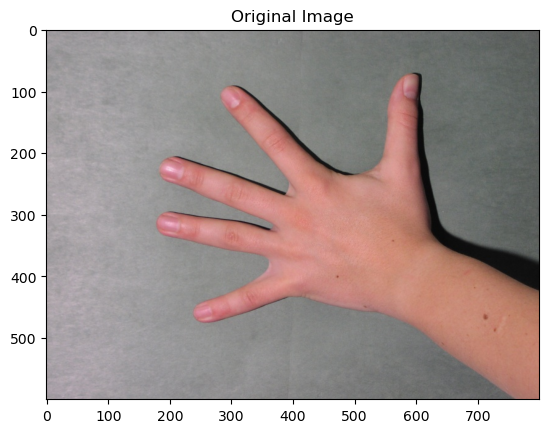

In [3]:
# set image path
path = './data/hand.jpg'
# read imgs
img = cv.imread(path)
display_1_rgb("Original Image", img)

In [4]:


def get_coordinates():
    fpath = './data/hand_landmarks.txt'
    coord_arr = []
    with open(fpath,'r') as f:
        for line in f:
            line = line.replace("(","").replace(")","").strip()
            coord = list(map(int, line.split(",")))
            coord_arr.append(coord)
    return np.array(coord_arr, dtype=np.uint64)

landmark_points = get_coordinates()


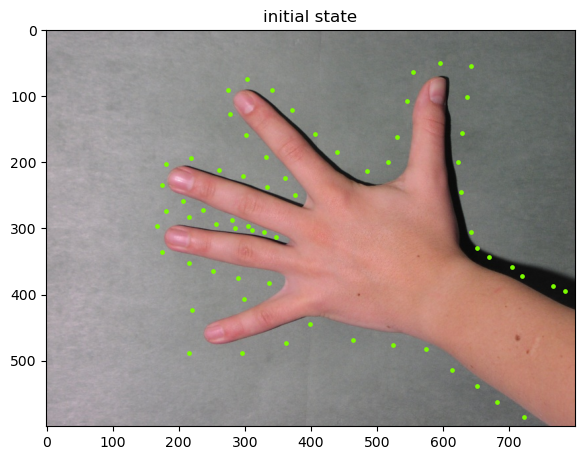

In [5]:
display_image_with_points(img, landmark_points)

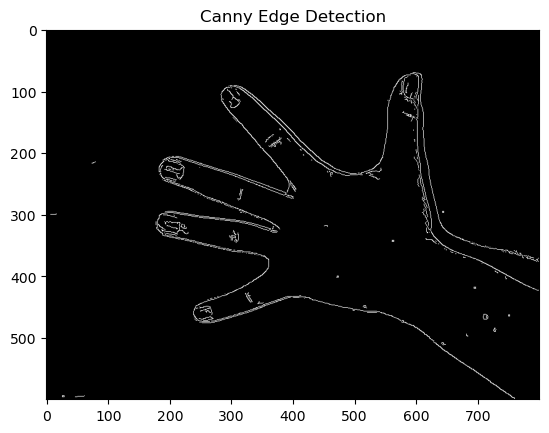

0 255
0.0 1.0


In [29]:
# find edges using Canny edge detector
edges = cv.Canny(img, 50, 100)

display_1_img("Canny Edge Detection", edges, mode="gray")
print(edges.min(), edges.max())

edges = edges.astype(np.float32)
edges /= 255
print(edges.min(), edges.max())

In [123]:
# compute euclidean distance transform for edges 
def euclidean_distance_transform(img):
    """
    Computes euclidean distance transform for given image.
    :param img: input image
    :return: euclidean distance transform of input image
    """
    # create a copy of input image
    img = img.copy()
    # get image shape
    h, w = img.shape
    # create a distance transform image
    dist = np.zeros_like(img)
    # set all non-zero pixels to infinity
    dist[img == 1] = 5
    # set all zero pixels to zero
    dist[img == 0] = 0
    # compute distance transform
    for i in range(1, h):
        for j in range(1, w):
            dist[i, j] = min(dist[i - 1, j - 1], dist[i - 1, j], dist[i, j - 1]) + 1
    return dist

In [126]:
def get_1d_distance_transform(f, n):
    d = np.zeros(n, dtype=np.float64)
    v = np.zeros(n, dtype=np.int32)
    z = np.zeros(n+1, dtype=np.float64)
    z[0] = -np.inf
    z[1] = np.inf
    k = 0
    for q in range(1, n):
        s = ((f[q] + q**2) - (f[v[k]] + v[k]**2))/(2*q - 2*v[k])
        # s = (((f[q] + q) - (f[v[k]] + v[k])))
        while s <= z[k]:
            k -= 1
            s = ((f[q] + q**2) - (f[v[k]] + v[k]**2))/(2*q - 2*v[k])
            # s = (((f[q] + q) - (f[v[k]] + v[k])))
        k += 1
        v[k] = q
        z[k] = s
        z[k+1] = np.inf
    k = 0
    for q in range(n):
        while z[k+1] < q:
            k += 1
        d[q] = (q - v[k])**2 + f[v[k]]
    
    return d

def get_2d_distance_transform(img):
    m, n = img.shape
    d = np.zeros((m, n), dtype=np.float64)
    for i in range(m):
        d[i, :] = get_1d_distance_transform(img[i, :], n)
    for j in range(n):
        d[:, j] = get_1d_distance_transform(d[:, j], m)
    return d


def dt_img(image):
    height = image.shape[0]
    width = image.shape[1]
    # Columns
    for x in range(width):
        f = image[:,x]
        image[:,x] = get_1d_distance_transform(f, height)
    # Rows
    for y in range(height):
        f = image[y,:]
        d = get_1d_distance_transform(f, width)
        image[y,:] = d
    return image


def get_2d_distance_transform_bin(img):
    m, n = img.shape
    k = 5000
    result = np.ones([m, n], dtype=np.float64)*k
    result[img==1]=0
    return dt_img(result)


dist_transf_img = get_2d_distance_transform_bin(edges)

In [124]:
# dist_transf_img = euclidean_distance_transform(edges)

# print(dist_transf_img.min(), dist_transf_img.max())

0.0 599.0


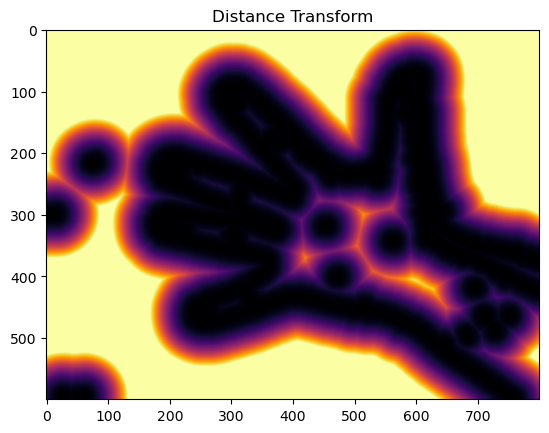

0.0 5000.0


In [127]:
display_1_img("Distance Transform", dist_transf_img, mode="fire")
print(dist_transf_img.min(), dist_transf_img.max())

In [17]:
# calculate the gradient of the distance transform image
gx, gy = np.gradient(dist_transf_img)

In [36]:
gx.shape

(600, 800)

In [128]:
# correspondences
def get_correspondences(dist_transf_img, gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2)
    grad_prod = gx*gy
    X = dist_transf_img/magnitude *grad_prod
    return X


    
# iterative closest point algorithm
def icp(A, B, max_iterations=100, tolerance=0.0001):
    

SyntaxError: unexpected EOF while parsing (2395647951.py, line 11)